In [98]:
import numpy as np
import pandas as pd
import statistics
import warnings
warnings.filterwarnings("ignore")

data_momentum=pd.read_excel('momentum_data.xlsx', sheet_name='momentum (excess returns)')

data_factor=pd.read_excel('momentum_data.xlsx', sheet_name='factors (excess returns)')

data_deciles=pd.read_excel('momentum_data.xlsx', sheet_name='deciles (total returns)')
data_size=pd.read_excel('momentum_data.xlsx', sheet_name='size_sorts (total returns)')
data_rf=pd.read_excel('momentum_data.xlsx', sheet_name='risk-free rate')

# 2.1 Momentum still profitable?

In [99]:
def subsample_func(dataset, start_date,end_date):
    df_subsample= dataset[(dataset['Date'].dt.year>= start_date) & (dataset['Date'].dt.year<= end_date)  ]
    df_subsample.drop(['Date'],axis=1, inplace=True)
    df_subsample.dropna(inplace=True)
    return df_subsample
def stats_ff(dataset1,dataset_factor):
    scale_factor=12
    annual_mean =dataset1.iloc[:,0].mean() * scale_factor
    annual_std =dataset1.iloc[:,0].std() * np.sqrt(scale_factor)
    annual_sharpe =annual_mean/annual_std
    skewness =dataset1.iloc[:,0].skew()
    corr_MKT_df = pd.DataFrame({
    'Rf': dataset1.iloc[:,0],
    'MKT': dataset_factor['MKT']
    })
    corr_HML_df = pd.DataFrame({
        'Rf': dataset1.iloc[:,0],
        'HML': dataset_factor['HML']
    })
    corr_MKT=corr_MKT_df.corr().loc['Rf', 'MKT']
    corr_HML=corr_HML_df.corr().loc['Rf', 'HML']

    stat_df = pd.DataFrame([{
    'Annualized Mean': annual_mean,
    'Annualized Vol': annual_std,
    'Sharpe': annual_sharpe,
    'Skewness': skewness,
    'Corr to Mkt Return': corr_MKT,
    'Corr to HML Return': corr_HML
    }])
    for col in stat_df.columns:
        stat_df[col] = stat_df[col].apply(lambda x: f"{x * 100:.1f}%")
    return stat_df
    

In [100]:
df1 =stats_ff(subsample_func(data_momentum,1927,2024),subsample_func(data_factor,1927,2024))
df2 =stats_ff(subsample_func(data_momentum,1927,1993),subsample_func(data_factor,1927,1993))
df3 =stats_ff(subsample_func(data_momentum,1994,2008),subsample_func(data_factor,1994,2008))
df4 =stats_ff(subsample_func(data_momentum,2009,2025),subsample_func(data_factor,2009,2025))
df_stats=pd.concat([df1,df2,df3,df4])
df_stats.index=['1927-2025','1927-1993','1994-2008','2009-2025']
df_stats

,Annualized Mean,Annualized Vol,Sharpe,Skewness,Corr to Mkt Return,Corr to HML Return
1927-2025,7.4%,16.3%,45.4%,-306.7%,-34.9%,-41.0%
1927-1993,8.8%,16.1%,54.9%,-391.1%,-36.7%,-50.1%
1994-2008,10.3%,17.5%,58.6%,-59.6%,-24.0%,-12.0%
2009-2025,-1.4%,15.6%,-9.0%,-267.6%,-35.9%,-32.5%


# 2.2 Whether a long-only implementation of momentum is valuable.

In [101]:
data_size_df=subsample_func(data_size,1994,2025)
data_rf_df=subsample_func(data_rf,1994,2025)
mom_long = (data_size_df['BIG HiPRIOR'] + data_size_df['SMALL HiPRIOR'])/2 - data_rf_df['RF']
mom_long_df=mom_long.to_frame('Rf_ff')
df1 =stats_ff(subsample_func(data_momentum,1994,2025),subsample_func(data_factor,1994,2025))
df2 = stats_ff(mom_long_df, subsample_func(data_factor, 1994, 2025))
df_stats=pd.concat([df1,df2])
df_stats.index=['Long and Short','Long Only']
df_stats

,Annualized Mean,Annualized Vol,Sharpe,Skewness,Corr to Mkt Return,Corr to HML Return
Long and Short,4.1%,16.6%,24.9%,-145.2%,-30.6%,-21.5%
Long Only,11.5%,17.8%,64.5%,-44.5%,90.5%,-12.4%


In [102]:
import matplotlib.pyplot as plt
def plot_cummulative(dataset1, dataset2):
    cum_return_df = pd.DataFrame()
    df_combined=pd.concat([dataset1,dataset2], axis=1)
    plt.figure()
    for col in df_combined.columns:
        cum_return_df[col] = (1 + df_combined[col]).cumprod() - 1
        plt.plot( cum_return_df[col], label=col)
    plt.title("Cumulative Return Curve")
    plt.xlabel("Year")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid()
    plt.show()

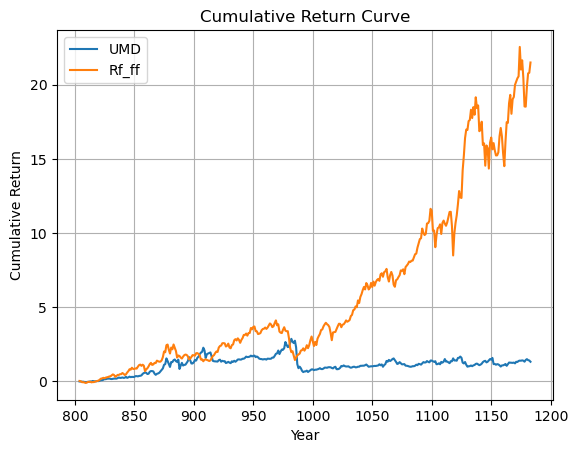

In [103]:
plot_cummulative(subsample_func(data_momentum,1994,2025),mom_long_df )

# 2.3 Is momentum just data mining, or is it a robust strategy?

In [114]:
data_deciles_df=subsample_func(data_deciles,1994,2025)
df_5decile= (1/5*(data_deciles_df.iloc[:, -5:].sum(axis=1)-data_deciles_df.iloc[:, :5].sum(axis=1))).to_frame('R_mom')
df_5decile

,R_mom
804,-0.00176
805,-0.00048
806,-0.00812
807,-0.00298
808,-0.01128
...,...
1179,0.04124
1180,-0.00064
1181,-0.02200
1182,0.00868


In [113]:
data_deciles_df=subsample_func(data_deciles,1994,2025)
df_1decile =(data_deciles_df['Hi PRIOR'] - data_deciles_df['Lo PRIOR']).to_frame('R_mom')
df_3decile= (1/3*(data_deciles_df.iloc[:, -3:].sum(axis=1)-data_deciles_df.iloc[:, :3].sum(axis=1))).to_frame('R_mom')
df_5decile= (1/5*(data_deciles_df.iloc[:, -5:].sum(axis=1)-data_deciles_df.iloc[:, :5].sum(axis=1))).to_frame('R_mom')

df1 =stats_ff(df_1decile,subsample_func(data_factor,1994,2025))
df2 =stats_ff(df_3decile,subsample_func(data_factor,1994,2025))
df3 =stats_ff(df_5decile,subsample_func(data_factor,1994,2025))
df4 =stats_ff(subsample_func(data_momentum,1994,2025),subsample_func(data_factor,1994,2025))

df_stats=pd.concat([df1,df2,df3,df4])
df_stats.index=['Decile 1','Decile 3','Decile 5','UMD']
df_stats

,Annualized Mean,Annualized Vol,Sharpe,Skewness,Corr to Mkt Return,Corr to HML Return
Decile 1,7.4%,29.9%,24.8%,-127.1%,-32.0%,-24.6%
Decile 3,2.7%,19.3%,13.9%,-132.0%,-35.4%,-22.1%
Decile 5,1.6%,13.4%,11.6%,-140.8%,-34.9%,-21.4%
UMD,4.1%,16.6%,24.9%,-145.2%,-30.6%,-21.5%


# 2.4 Does implementing momentum require trading lots of small stocks– thus causing even larger trading costs?

In [117]:
data_size_df=subsample_func(data_size,1994,2025)
r_small_df = (data_size_df['SMALL HiPRIOR'] - data_size_df['SMALL LoPRIOR']).to_frame('r_small')
r_large_df = (data_size_df['BIG HiPRIOR'] - data_size_df['BIG LoPRIOR']).to_frame('r_large')

df2 =stats_ff(r_small_df,subsample_func(data_factor,1994,2025))
df3 =stats_ff(r_large_df,subsample_func(data_factor,1994,2025))
df1 =stats_ff(subsample_func(data_momentum,1994,2025),subsample_func(data_factor,1994,2025))

df_stats=pd.concat([df1,df2,df3])
df_stats.index=['All stock','Small Stocks','Big stocks']
df_stats

,Annualized Mean,Annualized Vol,Sharpe,Skewness,Corr to Mkt Return,Corr to HML Return
All stock,4.1%,16.6%,24.9%,-145.2%,-30.6%,-21.5%
Small Stocks,6.2%,16.8%,36.9%,-181.3%,-30.9%,-13.9%
Big stocks,2.1%,18.2%,11.4%,-85.5%,-27.3%,-26.5%
